### IO example for NaCl electronic band structure using Conquest
> The objective is to use ASE for pre-process (building the **I**nput files) and
> post-process (having the **O**utput file) a Conquest calculation. 
> The calculation *must* be run at hand,
> that is, the calculation is not launched by ASE.

<div class="alert alert-block alert-danger">
    <b>WARNING:</b> IO example requirements
</div>    

> `ASE version = 3.20.0b1` including `Conquest`



In [1]:
import os
import shutil
import subprocess
import matplotlib.pyplot as plt
import pickle

from distutils.spawn import find_executable
from numpy import amax, amin, size, array, trapz, floor

from ase.units import Hartree
from ase.build import bulk
from ase.calculators.conquest import Conquest
from ase.io.conquest import Conquest_orthorhombic_check
from ase.io.conquest import get_fermi_level
#from ase.io.conquest import read_conquest

from ase.dft.bandgap import bandgap
from ase.dft.dos import DOS
from ase.visualize import view
from ase.spacegroup import get_spacegroup
from ase import Atoms

from cq_ase_external_lib import print_struct_data
from cq_ase_external_lib import get_gapwind

In [2]:
%%bash 
ase --version

ase-3.20.0b1_cq


#### Check if visualisation tools are installed

In [3]:
# Add exe name 
cmd_vis = {'xcrysden' : False}

for cmd, state in cmd_vis.items():
    if ( not shutil.which(cmd) ):
        print('{} not found'.format(cmd))
    else:
        print('{} found'.format(cmd))   
        cmd_vis[cmd] = True
        
# For MacOSX add the path of the name of the app
cmd_app = {'VESTA'      : '/Applications/VESTA/VESTA.app/Contents/MacOS/VESTA',
           'VMDLauncher': '/Applications/VMD_1.9.2.app/Contents/MacOS/VMDLauncher'}

for cmd, path in cmd_app.items():
    if ( not find_executable(path) ):
        print('{} not found'.format(cmd))
    else:
        print('{} found'.format(cmd))   

xcrysden found
VESTA found
VMDLauncher not found


#### Directory for storing calculation files

In [4]:
working_directory = 'cq_example_rocksalt_bands_io'

# Test if `working_directory` exists ? If not create it
if ( not os.path.isdir(working_directory) ):
    os.makedirs(working_directory)

#### Define Conquest environment

In [5]:
os.environ['ASE_CONQUEST_COMMAND'] = 'mpirun -np 4 /Users/lioneltruflandier/CONQUEST-release-f-rework-output-ase/src/Conquest'
#os.environ['ASE_CONQUEST_COMMAND'] = 'mpirun -np 4 /Users/lioneltruflandier/CONQUEST-develop/src/Conquest'
os.environ['CQ_PP_PATH'] = '/Users/lioneltruflandier/Conquest-develop-outdated/pseudo-and-pao'
os.environ['CQ_GEN_BASIS_CMD'] = '/Users/lioneltruflandier/CONQUEST-release-develop/tools/BasisGeneration/MakeIonFiles'

#### Setup Conquest basis set

In [6]:
basis = {'Na' : {'gen_basis'            : True,
                 'basis_size'           : 'small',
                 'pseudopotential_type' : 'hamann',
                 'xc'                   : 'PBE' },
         'Cl' : {'gen_basis'            : False,
                 'basis_size'           : 'small',
                 'pseudopotential_type' : 'hamann'}
        }

val_elec = {'Na': 9, 'Cl': 7}

#### Generate rocksalt cell from CIF file data

- Choose either primitive or conventional cell

In [7]:
primitive = True

- Generate rocksalt struture with $a=5.71$ Ang.

In [8]:
if ( primitive ):
    # For primitive cell
    struct = bulk('NaCl', crystalstructure='rocksalt', a=5.71, cubic=False)
    # Conquest can only handle orthorhombic cells ; check
    struct = Conquest_orthorhombic_check(struct,verbose=False)
    # warning must be printed and 'struct' is modified to conventional cell
    
else:
    # For conventional cell
    struct = bulk('NaCl', crystalstructure='rocksalt', a=5.71, cubic=True)
    # Conquest can only handle orthorhombic cells ; check
    struct = Conquest_orthorhombic_check(struct,verbose=False)
    # no warning...

## ConquestWarning ##
file: /Users/lioneltruflandier/Conquest-ase/ase/ase/io/conquest.py , line: 108
>>>>  Current cell not orthorhombic:
Bravais lattice:
   FCC(a=5.71)
Space group:
   Fm-3m (225)
Cell parameters (Ang. and degree):
   a =       4.037580
   b =       4.037580
   c =       4.037580
   alpha =  60.0000
   beta  =  60.0000
   gamma =  60.0000


## ConquestWarning ##
file: /Users/lioneltruflandier/Conquest-ase/ase/ase/io/conquest.py , line: 122
>>>>  New orthorhombic cell:
Bravais lattice:
   CUB(a=5.71)
Space group:
   Fm-3m (225)
Cell parameters (Ang. and degree):
   a =       5.710000
   b =       5.710000
   c =       5.710000
   alpha =  90.0000
   beta  =  90.0000
   gamma =  90.0000


#### Compute the number of states
- Given `struct`and the `val_elec`compute the total number of electrons

In [9]:
# Get atom labels
atom_names = struct.get_chemical_symbols()

# Compute total valence electrons
tot_val = 0
for i in range(len(struct)):
    for key, val in val_elec.items():
        if ( key == atom_names[i] ):
            tot_val = tot_val + val

print('Number of valence electron in the unit cell = ', tot_val)

Number of valence electron in the unit cell =  64


- Compute number(s) of occupied states

In [10]:
n_occ = []
if ( tot_val % 2 == 0):
    # paired electrons
    n_occ.append(int(tot_val/2))
else:
    # unpaired electrons
    n_occ.append(int((tot_val-1)/2))
    n_occ.append(int((tot_val+1)/2))
    
print()
print('Number of occupied bands = ', n_occ)


Number of occupied bands =  [32]


#### Extract and print main structural data from Atoms object (here `struct`)

In [11]:
print_struct_data(struct,verbose=1)

Cartesian atomic positions (Ang.)
  Na      0.000000      0.000000      0.000000
  Cl      2.855000      0.000000      0.000000
  Na      0.000000      2.855000      2.855000
  Cl      2.855000      2.855000      2.855000
  Na      2.855000      0.000000      2.855000
  Cl      0.000000      0.000000      2.855000
  Na      2.855000      2.855000      0.000000
  Cl      0.000000      2.855000      0.000000

Fractional atomic positions (Adim.)
  Na      0.000000      0.000000      0.000000
  Cl      0.500000      0.000000      0.000000
  Na      0.000000      0.500000      0.500000
  Cl      0.500000      0.500000      0.500000
  Na      0.500000      0.000000      0.500000
  Cl      0.000000      0.000000      0.500000
  Na      0.500000      0.500000      0.000000
  Cl      0.000000      0.500000      0.000000

Cell tensor (Ang.)
          5.710000      0.000000      0.000000
          0.000000      5.710000      0.000000
          0.000000      0.000000      5.710000

Cartesian atomi

- Space group ; Brillouin zone of space group [225](https://www.cryst.ehu.es/cgi-bin/cryst/programs/nph-kv-list?gnum=225&fig=fm3qmf&what=data)

In [12]:
sg = get_spacegroup(struct)
print('Space group: {} ({}) '.format(sg.symbol,sg.no))

Space group: F m -3 m (225) 


- Save input structure as VASP `POSCAR` file & `CIF` file (for checking purpose)

In [13]:
struct.write(working_directory+'/input.vasp')
struct.write(working_directory+'/input.cif')

- run `VESTA` to check input (if possible) from `input.cif`

In [14]:
#if ( 'VESTA' in cmd_app ):
#    subprocess.run([cmd_app['VESTA'], working_directory+'/'+'input.cif'])

#### Setup calculation using Conquest as calculator

In [15]:
cutoff  =  80.0
kpoints = [3,3,3]
fxc     = 'PBE'

conquest_flags = {'IO.WriteOutToASEFile' : 'True',
                  'IO.DumpChargeDensity' : 'True'}

calc = Conquest(directory      = working_directory,
                grid_cutoff    = cutoff,
                self_consistent= True,
                xc    = fxc,
                basis = basis,
                kpts  = kpoints,
                nspin = 1,
                **conquest_flags)

struct.calc = calc

input basis:
Na {'gen_basis': True, 'basis_size': 'small', 'pseudopotential_type': 'hamann', 'xc': 'PBE'}
input basis:
Cl {'gen_basis': False, 'basis_size': 'small', 'pseudopotential_type': 'hamann'}


#### Generate Conquest input for SCF calculation

- input file `Conquest_input` is stored in `./working_directory`

In [16]:
struct.calc.write_input(struct)

## ConquestWarning ##
file: /Users/lioneltruflandier/Conquest-ase/ase/ase/calculators/conquest.py , line: 275
>>>>  Na.ion taken from cq_example_rocksalt_bands_io/Na.ion
## ConquestWarning ##
file: /Users/lioneltruflandier/Conquest-ase/ase/ase/calculators/conquest.py , line: 275
>>>>  Cl.ion taken from cq_example_rocksalt_bands_io/Cl.ion
output basis:
Na {'gen_basis': True, 'basis_size': 'small', 'pseudopotential_type': 'hamann', 'xc': 'PBE'}
output basis:
Cl {'gen_basis': False, 'basis_size': 'small', 'pseudopotential_type': 'hamann', 'xc': 'PBE'}


<div class="alert alert-block alert-danger">
    <b>WARNING:</b> you must have run the calculation somewhere and store the output files in the working directory
    </b>
</div>

Mandatory output file(s):
- `Conquest_out_ase`

#### Backup SCF files

- copy SCF calculation input/output files 

In [17]:
subprocess.run(['cp', working_directory+'/'+'Conquest_input', 
                working_directory+'/'+'Conquest_input_scf'])

subprocess.run(['cp', working_directory+'/'+'Conquest_out', 
                working_directory+'/'+'Conquest_out_scf'])

subprocess.run(['cp', working_directory+'/'+'Conquest_out_ase', 
                working_directory+'/'+'Conquest_out_ase_scf'])

CompletedProcess(args=['cp', 'cq_example_rocksalt_bands_io/Conquest_out_ase', 'cq_example_rocksalt_bands_io/Conquest_out_ase_scf'], returncode=0)

#### Read results (from `Conquest_out_ase` file)

In [18]:
struct.calc.read_results(struct)

#### Extract Fermi energy from SCF 

In [19]:
fermi_energy_scf = struct.calc.eFermi

#### Band-path print

CUB(a=5.71)
  Variant name: CUB
  Special point names: GXRM
  Default path: GXMGRX,MR

  Special point coordinates:
    G   0.0000  0.0000  0.0000
    X   0.0000  0.5000  0.0000
    R   0.5000  0.5000  0.5000
    M   0.5000  0.5000  0.0000



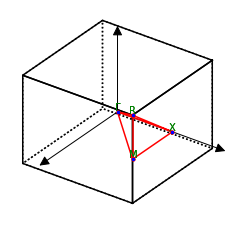

<Axes3DSubplot:>

In [20]:
latt  = struct.cell.get_bravais_lattice()
print(latt.description())
#print('lattice = ', latt)
#print('special k-point = ',list(latt.get_special_points()))

primitive = False

if ( primitive ):
    # For primitive cell
    path = 'WLGXWK'
else:
    # For conventional cell
    path = 'GXMGRX,MR'

latt.plot_bz(show=True,path=path)

#print('k-point array shape =',size1,'x',size2)
#print('k-point coord list (fractional coord.)')
#print(kpath.kpts) 

#### Band structure calculation setup

In [21]:
conquest_flags = {'General.LoadRho' : True, 'IO.DumpChargeDensity' : False}
nkpoints = 100 

- Setup kpoint mesh in Conquest bands input

In [22]:
path  = 'GXRM'
kpath = struct.cell.bandpath(path, npoints=nkpoints)
print(kpath)
Changed_parameters = struct.calc.set(kpts=kpath.kpts,self_consistent=False,**conquest_flags)

BandPath(path='GXRM', cell=[3x3], special_points={GMRX}, kpts=[100x3])


- ...or Setup kpoint lines in Conquest bands input

In [23]:
#kpts_lines = {'path': 'GXRM', 'npoints': nkpoints, 'special_points' : '{GXRM}'}
#changed_parameters = calc.set(kpts=kpts_lines,self_consistent=False,**conquest_flags)

#### Generate Conquest input for bands calculation
- input file `Conquest_input` is stored in `./working_directory`

In [24]:
struct.calc.write_input(struct)

<div class="alert alert-block alert-danger">
    <b>WARNING:</b> you must have run the calculation somewhere and store the output files in the working directory
    </b>
</div>

Mandatory output file(s):
- `Conquest_out_ase`

#### Read results from band structure calculation

In [27]:
struct.calc.read_results()

#### Extract band structure

In [30]:
bs = calc.band_structure()

#### Extract higher occupied (ho) and lower unoccupied (lu) energy level from bands

In [ ]:
ho, lu = get_gapwind( calc, kpath, n_occ )
print('higher   occupied energy = {:.4f} eV @kpt {} => {}'.format(ho[0],ho[1],kpath.kpts[ho[1]]))
print('lowest unoccupied energy = {:.4f} eV @kpt {} => {}'.format(lu[0],lu[1],kpath.kpts[lu[1]]))
print('band gap = {:.4f} eV'.format(lu[0] - ho[0]))
fermi_energy_bands = ho[0]

#### Choose wich Fermi level to use for bands and DOS post-processing 

> you have choice between `fermi_energy_scf` and `fermi_energy_bands`. For insulator, the first one is evaluated to be within the gap. The second one is setup at the highest occupied energy level.

In [ ]:
print('fermi SCF   = {:12.4f} eV'.format(fermi_energy_scf))
print('fermi bands = {:12.4f} eV'.format(fermi_energy_bands))
fermi_energy = fermi_energy_scf
fermi_energy = fermi_energy_bands

#### Setup energy reference for band structure plot

In [ ]:
bs._reference = fermi_energy

# Rescaled energies if needed : Fermi energy setup to 0.0 !
bs._energies  = bs._energies  - fermi_energy
bs._reference = bs._reference - fermi_energy

#### Print Fermi energy and energy spectrum bounds

In [ ]:
print('fermi = {:12.4f} eV'.format(fermi_energy))
e_max = amax(bs.energies) ; print('e_max = {:12.4f} eV'.format(e_max))
e_min = amin(bs.energies) ; print('e_min = {:12.4f} eV'.format(e_min))

#### Compute DOS ; Fermi energy must be given

In [ ]:
dos = DOS(calc, width=0.2, fermi=[fermi_energy-bs._reference])
d = dos.get_dos() / 2 # correct for ASE spin unpolarized
e = dos.get_energies() 

#### Print band structure and DOS

In [ ]:
# Choose energy window [e_min, e_max]
e_max =  14.0
e_min = -25.0

fig, (ax0, ax1) = plt.subplots(1,2)

# Plot DOS on ax1
ax1.plot(d, e, color='black')

# Compute and plot integrated dos
sum_dos = 0.0 ; sum_dos_acc=[0.0]
for i in range(len(d)-1):
    sum_dos = sum_dos + d[i+1] * (e[i+1] - e[i])
    sum_dos_acc.append(sum_dos)
ax1.plot(array(sum_dos_acc), e, color='black')

ax1.set_xlabel('state count')
ax1.set_ylim(e_min,e_max)
ax1.axhline(bs.reference, color='k', ls=':')
ax1.axvline(n_occ[0], color='k', ls=':', linewidth=0.2)
ax1.set_xlim(0.0,n_occ[0])

# Plot band structure on ax0
ax0.set_xlabel('$k$-path')
bs.plot(ax0,emin=e_min, emax=e_max, show=True,color='black')

#### Save figure as `bands.png` in ` working_directory`

In [ ]:
fig.savefig(working_directory+'/'+'bands.png', dpi=300, format='png', transparent=True)

#### Integrate DOS (checking purpose)

In [ ]:
# integrate DOS using trapezoidal rule
sum_dos = trapz(d,e)

# integrate DOS up to Fermi level
i = 0 ; sum_dos_ef = 0.0 ; e_ = e[0]
while( e_ <= bs._reference ):
        sum_dos_ef = sum_dos_ef + d[i+1]*(e[i+1] - e[i])
        e_ = e[i+1]
        i += 1

print('integrated DOS up to {:12.4f} = {:.4f}'.format(e[-1],sum_dos))
print('integrated DOS up to {:12.4f} = {:.4f}'.format(bs._reference,sum_dos_ef))

#### Compute direct and indirect band gap

In [ ]:
#WARNING: accuracy issue from ASE 'bandgap' (not yet resolved)
#solution: add epsilon to bs._reference (fermi_energy)
eps = 1e-6
gap, p1, p2 = bandgap(calc,efermi=fermi_energy+eps,direct=True)
gap, p1, p2 = bandgap(calc,efermi=fermi_energy+eps,direct=False)